<a href="https://colab.research.google.com/github/myidispg/deep_learning_specialization/blob/master/CNN/Week%202/PyTorch_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

data_dir = './data'
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.MNIST('/files/', train=True, download=True, 
                                      transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST('/files/', train=False, download=True,
                                      transform=transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

trainloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True)

testloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

print(len(trainloader.dataset))

60000


# Plotting some images from both the train and test set

Plotting 10 random images from the train set and their corresponding labels...


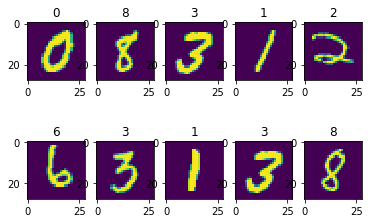

In [9]:
# To unnormalize the image and put channel after the image height and width.
def im_show_process(img):
  img = (img / 2) + 0.5 # Unnormalize the image
  img = img.numpy()
  
  # Since, PyTorch needs channels before the height and width and
  # matplotlib needs channels afterwards, transpose them to make images compatible.
  return np.transpose(img, (1, 2, 0)).reshape(img.shape[1], -1)

print(f'Plotting 10 random images from the train set and their corresponding labels...')
dataiter = iter(trainloader)
images, labels = dataiter.next()

f, axarr = plt.subplots(2, 5)

for i in range(2):
  for j in range(5):
    index = np.random.randint(0, 64)
    axarr[i, j].imshow(im_show_process(images[index]))
    axarr[i, j].set_title(classes[labels[index]])

Plotting 10 random images from the test set and their corresponding labels...


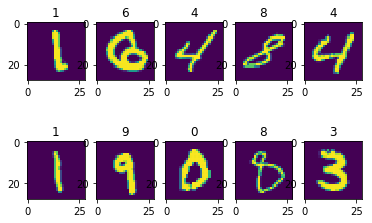

In [10]:
print(f'Plotting 10 random images from the test set and their corresponding labels...')
dataiter = iter(testloader)
images, labels = dataiter.next()

f, axarr = plt.subplots(2, 5)

for i in range(2):
  for j in range(5):
    index = np.random.randint(0, 64)
    axarr[i, j].imshow(im_show_process(images[index]))
    axarr[i, j].set_title(classes[labels[index]])

## Thanks to PyTorch datasets, not much of anything is required.
### Next step: Building the model.

In [11]:
import torch.nn as nn
import torch.nn.functional as F


class IdentityBlock(nn.Module):
  """
  Implementing an identity block where the dimensions of both the opearands 
  while implementing the skip connection should be same.
  
  Inputs:
  X: Input tensor of shape(m, n_channels, n_H, n_W)
  f: filter size for the middle convolutional layer of the main path.
  filters: A list of 3 integers specifying the number of filters at each layer
           in the main path.
  in_channels = Number of input channels
  """
  
  def __init__(self, f, filters, in_channels):
    super(IdentityBlock, self).__init__()
    
    F1, F2, F3 = filters
    
    # First component in the main path
    self.conv1 = nn.Conv2d(in_channels, F1, kernel_size=(1,1), stride=(1,1))
    self.batch_norm1 = nn.BatchNorm2d(F1)
    
    # Second component in the main path
    # Since PyTorch does not implement valid padding and same padding,
    # manually apply padding to cover case of both even and odd filter size.
    pad = (f-1)//2
    self.conv2 = None
    self.is_zero_pad = False
    if f%2 == 0: # If the filter size is even, padding only the right side.
      limit = f-1
      pad_1 = (f-1)//2
      pad_2 = limit-pad_1
      self.is_zero_pad = True
      self.zero_pad = nn.ZeroPad2d((pad_1, pad_2, pad_1, pad_2))
      self.conv2 = nn.Conv2d(F1, F2, kernel_size=(f,f), stride=(1,1), padding=0)
    else:
      self.conv2 = nn.Conv2d(F1, F2, kernel_size=(f,f), stride=(1,1), 
                             padding=pad)
    self.batch_norm2 = nn.BatchNorm2d(F2)
    
    # Third component in the main path
    self.conv3 = nn.Conv2d(F2, F3, kernel_size=(1,1), stride=(1,1))
    self.batch_norm3 = nn.BatchNorm2d(F3)
    
    self.relu = nn.ReLU()
    
  def layer(self, X):
    X_shortcut = X
#     print(f'Shape of shortcut: {X.shape}')
    
    X = self.relu(self.batch_norm1(self.conv1(X)))
#     print(f'After 1: {X.shape}')
#     print(f'SHape zero pad: {self.zero_pad(X).shape}')

    if self.is_zero_pad:
      X = self.relu(self.batch_norm2(self.conv2(self.zero_pad(X))))
    else:
      X = self.relu(self.batch_norm2(self.conv2(X)))

#     print(f'After 2: {X.shape}')
    X = self.batch_norm3(self.conv3(X))
    
#     print(f'After 3: {X.shape}')
    X += X_shortcut
    return self.relu(X)
    
    
test = IdentityBlock(f=3, filters=[256, 256, 1024], in_channels=1024)
image = torch.randn((3, 1024, 1, 1))
image = test.layer(image)
print(image.shape)

torch.Size([3, 1024, 1, 1])


In [12]:
class ConvolutionalBlock(nn.Module):
  """
  Implementing the convolutional block where the operands of the skip
  connection are of different sizes.
  """
  
  def __init__(self, f, filters, in_channels, stride=2):
    super(ConvolutionalBlock, self).__init__() 
    
    # Retrieving the filters
    F1, F2, F3 = filters
     
    # First component in main path
    self.conv1 = nn.Conv2d(in_channels, F1, kernel_size=(1,1), 
                           stride=(stride, stride))
    self.batch_norm1 = nn.BatchNorm2d(F1)
    
    # Second component in the main path
    # Since PyTorch does not implement valid padding and same padding,
    # manually apply padding to cover case of both even and odd filter size.
    pad = (f-1)//2
    self.conv2 = None
    self.is_zero_pad = False
    if f%2 == 0: # If the filter size is even, padding only the right side.
      limit = f-1
      pad_1 = (f-1)//2
      pad_2 = limit-pad_1
      self.is_zero_pad = True
      self.zero_pad = nn.ZeroPad2d((pad_1, pad_2, pad_1, pad_2))
      self.conv2 = nn.Conv2d(F1, F2, kernel_size=(f,f), stride=(1,1), padding=0)
    else:
      self.conv2 = nn.Conv2d(F1, F2, kernel_size=(f,f), stride=(1,1),
                             padding=pad)
    self.batch_norm2 = nn.BatchNorm2d(F2)
    
    # Third component in the main path
    self.conv3 = nn.Conv2d(F2, F3, kernel_size=(1,1), stride=(1,1))
    self.batch_norm3 = nn.BatchNorm2d(F3)
    
    # Shortcut path. Making sure the dimensions match.
    self.conv_shortcut = nn.Conv2d(in_channels, F3, kernel_size=(1,1), 
                                   stride=(stride, stride))
    # this is same as the third batch norm. Seperate for readability purpose.
    self.batch_norm_shortcut = nn.BatchNorm2d(F3) 
    
    self.relu = nn.ReLU()
    
  def layer(self, X):
    X_shortcut = X
#     print(f'Input_shape: {X.shape}')
    X = self.relu(self.batch_norm1(self.conv1(X)))
#     print(f'After 1: {X.shape}')
    
    if self.is_zero_pad:
      X = self.relu(self.batch_norm2(self.conv2(self.zero_pad(X))))
    else:
      X = self.relu(self.batch_norm2(self.conv2(X)))
#     print(f'After 2: {X.shape}')
    
    X = self.batch_norm3(self.conv3(X))
#     print(f'After 3: {X.shape}')
    
    # Implement the shortcut path
    X_shortcut = self.batch_norm_shortcut(self.conv_shortcut(X_shortcut))
#     print(f'After shortcut: {X_shortcut.shape}')
    X += X_shortcut
      
    return self.relu(X)
  
conv_block = ConvolutionalBlock(f=3, filters=[512, 512, 2048], in_channels=1024, stride=2)
image = torch.randn((3, 1024, 1, 1))
image = conv_block.layer(image)
print(image.shape)

torch.Size([3, 2048, 1, 1])


## Building the Resnet 50 model.

We now have the building blocks for the model. Now, the architecture is defined as:


*   Zero Padding the input with a pad of (3,3)
*   Stage 1:
  *  The 2D Convolution has 64 filters of shape (7,7) ans uses a stride of (2, 2)
  * Batch Normalization is applied
  * MaxPooling (3,3) window and (2,2) stride.
*   Stage 2: 
  *  The convolutional block uses three set of filters of size [64,64,256], "f" is 3, "s" is 1
  *  The 2 identity blocks use three set of filters of size [64,64,256], "f" is 3
*   Stage 3:
  *  The convolutional block uses three set of filters of size [128,128,512], "f" is 3, "s" is 2
  *  The 3 identity blocks use three set of filters of size [128,128,512], "f" is 3
*   Stage 4:
  *  The convolutional block uses three set of filters of size [256, 256, 1024], "f" is 3, "s" is 2
  *  The 5 identity blocks use three set of filters of size [256, 256, 1024], "f" is 3
*   Stage 5:
  *  The convolutional block uses three set of filters of size [512, 512, 2048], "f" is 3, "s" is 2
  *  The 2 identity blocks use three set of filters of size [512, 512, 2048], "f" is 3 
*   The 2D Average Pooling uses a window of shape (2,2) and its name is "avg_pool".
*   The flatten doesn't have any hyperparameters or name.
*   The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

In [0]:
class Resnet(nn.Module):
  """
  The input for the CIFAR images will be: (m, 3, 32, 32)
  Output of pooling = ((i-f)/s) + 1
  """
  def __init__(self,in_shape, num_classes):
    super(Resnet, self).__init__()
    
    if len(in_shape) == 4:
      in_channels = in_shape[1]
    else:
      in_channels = in_shape[0]
    
    self.relu = nn.ReLU()
    
    self.initial_zero_pad = nn.ZeroPad2d((3,3)) # Output= (32,32)
    
    # Stage 1
    self.conv1 = nn.Conv2d(in_channels, out_channels=64, kernel_size=(7,7),
                          stride=(2,2), padding=0) # Output -> (16,16,64)
    self.batch_norm1 = nn.BatchNorm2d(64)
    self.max_pool_1 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)) # Output->(7,7)
    # Output channels = 64
    
    # Stage 2
    self.conv_block_2_1 = ConvolutionalBlock(f=3, filters=[64, 64, 256], in_channels=64, stride=2) # Output -> (4, 4, 256)
    self.id_block_2_1 = IdentityBlock(f=3, filters=[64, 64, 256], in_channels=256) # Output -> (4, 4, 256)
    self.id_block_2_2 = IdentityBlock(f=3, filters=[64, 64, 256], in_channels=256) # Output -> (4, 4, 256)
    # Output channels = 256
    
    # Stage 3
    self.conv_block_3_1 = ConvolutionalBlock(f=3, filters=[128,128,512], in_channels=256, stride=2) # Output -> (512, 2, 2)
    self.id_block_3_1 = IdentityBlock(f=3, filters=[128,128,512], in_channels=512) # Output -> (512, 2, 2)
    self.id_block_3_2 = IdentityBlock(f=3, filters=[128,128,512], in_channels=512) # Output -> (512, 2, 2)
    self.id_block_3_3 = IdentityBlock(f=3, filters=[128,128,512], in_channels=512) # Output -> (512, 2, 2)
    # Output channels = 512
    
    # Stage 4
    self.conv_block_4_1 = ConvolutionalBlock(f=3, filters=[256, 256, 1024], in_channels=512, stride=2) # Output -> (1024, 1, 1)
    self.id_block_4_1 = IdentityBlock(f=3, filters=[256, 256, 1024], in_channels=1024) # Output -> (1024, 1, 1)
    self.id_block_4_2 = IdentityBlock(f=3, filters=[256, 256, 1024], in_channels=1024) # Output -> (1024, 1, 1)
    self.id_block_4_3 = IdentityBlock(f=3, filters=[256, 256, 1024], in_channels=1024) # Output -> (1024, 1, 1)
    self.id_block_4_4 = IdentityBlock(f=3, filters=[256, 256, 1024], in_channels=1024) # Output -> (1024, 1, 1)
    self.id_block_4_5 = IdentityBlock(f=3, filters=[256, 256, 1024], in_channels=1024) # Output -> (1024, 1, 1)
    # Output channels = 1024
    
    # Stage 5
    self.conv_block_5_1 = ConvolutionalBlock(f=3, filters=[512, 512, 2048], in_channels=1024, stride=2) # Output -> (2048, 1, 1)
    self.id_block_5_1 = IdentityBlock(f=3, filters=[512, 512, 2048], in_channels=2048) # Output -> (2048, 1, 1)
    self.id_block_5_2 = IdentityBlock(f=3, filters=[512, 512, 2048], in_channels=2048) # Output -> (2048, 1, 1)
    
    self.avg_pool = nn.AvgPool2d(kernel_size=(2,2), padding=(0, 0))
    
    # Fully connected layers after flattening
    self.fc1 = nn.Linear(2048, 512)
    self.fc2 = nn.Linear(512, 64)
    self.fc3 = nn.Linear(64, 10)
    
  def forward(self, X):
    
    X = self.initial_zero_pad(X)
    
    X = self.conv1(X)
    X = self.batch_norm1(X)
    X = self.max_pool_1(X)
    
    X = self.conv_block_2_1.layer(X)
    X = self.id_block_2_1.layer(X)
    X = self.id_block_2_2.layer(X)
    
    X = self.conv_block_3_1.layer(X)
    X = self.id_block_3_1.layer(X)
    X = self.id_block_3_2.layer(X)
    X = self.id_block_3_3.layer(X)
    
    X = self.conv_block_4_1.layer(X)
    X = self.id_block_4_1.layer(X)
    X = self.id_block_4_2.layer(X)
    X = self.id_block_4_3.layer(X)
    X = self.id_block_4_4.layer(X)
    X = self.id_block_4_5.layer(X)
    
    X = self.conv_block_5_1.layer(X)
    X = self.id_block_5_1.layer(X)
    X = self.id_block_5_2.layer(X)
    
    X = self.avg_pool(X)
    
    
    X = X.view(X.shape[0], -1)
    
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    
    return self.fc3(X)
    
    
resnet = Resnet((64,1, 28,28),5)
image = torch.randn((64,1, 28,28))
output = resnet(image)


###Instantiate the model and define loss and optimizer

In [0]:
import torch.optim as optim

model = Resnet((batch_size, 1, 28, 28), len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

###Train the model

In [24]:
epochs = 10
steps = 0
train_loss = []
validation_loss = []
validation_acc = []

running_loss = 0
print_every = 100

for epoch in range(epochs):
  
  for inputs, labels in trainloader:
    steps += 1 
    inputs, labels = inputs.to(device), labels.to(device)
    
    optimizer.zero_grad()
    
    logps = model(inputs)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    
    if steps % print_every == 0:
      test_loss = 0
      accuracy = 0
      model.eval()
      with torch.no_grad():
        for inputs, labels in testloader:
          inputs, labels = inputs.to(device), labels.to(device)
          logps = model(inputs)
          batch_loss = criterion(logps, labels)
          
          test_loss += batch_loss.item()
          
          # Calculate accuracy
          ps = torch.exp(logps)
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
          
        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {running_loss/print_every:.8f}.. "
              f"Test loss: {test_loss/len(testloader):.8f}.. "
              f"Test accuracy: {accuracy/len(testloader):.8f}")
        train_loss.append(running_loss/print_every)
        validation_loss.append(test_loss/len(testloader))
        validation_acc.append(accuracy/(len(testloader)))
        running_loss = 0
        model.train()
  
#   for i, data in enumerate(trainloader):
#     inputs, labels = data
#     inputs = inputs.to(device)
#     labels = labels.to(device)
    
#     optimizer.zero_grad()
    
#     outputs = model(inputs)
#     print(labels.shape)
#     print(output.shape)
#     loss = criterion(outputs, labels)
#     loss.backward() # loss for each batch
#     optimizer.step()
    
#     epoch_loss += loss.item()
#     running_loss += loss.item()
#     if (i) % 1999 == 0:
#       print(f'Epoch: {epoch+1}\tBatch: {i+1}\tLoss: {running_loss/2000}')
#       running_loss = 0
      
#   model.eval()
#   valid_loss = 0
#   correct = 0
#   with torch.no_grad():
#     for data, target in testloader:
#       output = model(data)
#       loss = criterion(output, loss)
#       valid_loss += loss.item()
      
#       _, pred = torch.topk(output, dim=1)
      
#       correct += (pred==target).sum().item()
      
      
print('Training Finished')

Epoch 1/10.. Train loss: 0.93981971.. Test loss: 0.60790528.. Test accuracy: 0.80951433
Epoch 1/10.. Train loss: 0.41613797.. Test loss: 0.23196400.. Test accuracy: 0.94108280
Epoch 1/10.. Train loss: 0.28983659.. Test loss: 0.21183453.. Test accuracy: 0.94167994
Epoch 1/10.. Train loss: 0.25010290.. Test loss: 0.20609024.. Test accuracy: 0.94725318
Epoch 1/10.. Train loss: 0.22808648.. Test loss: 0.16167872.. Test accuracy: 0.95630971
Epoch 1/10.. Train loss: 0.20004990.. Test loss: 0.15440485.. Test accuracy: 0.95810111
Epoch 1/10.. Train loss: 0.16673146.. Test loss: 0.13352510.. Test accuracy: 0.96606290
Epoch 1/10.. Train loss: 0.17785847.. Test loss: 0.13540387.. Test accuracy: 0.96476911
Epoch 1/10.. Train loss: 0.16379330.. Test loss: 0.16325110.. Test accuracy: 0.96437102
Epoch 2/10.. Train loss: 0.14654854.. Test loss: 0.11549868.. Test accuracy: 0.97133758
Epoch 2/10.. Train loss: 0.12005341.. Test loss: 0.11631099.. Test accuracy: 0.96765525
Epoch 2/10.. Train loss: 0.11164

Text(0.5, 1.0, 'Training Losses')

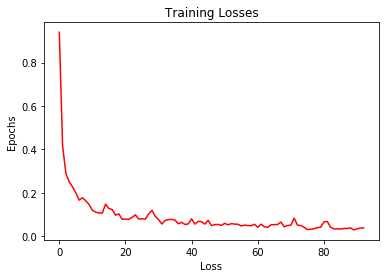

In [26]:
# Plot the training losses.
plt.plot(train_loss, color='r')
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title('Training Losses')

Text(0.5, 1.0, 'Validation Losses')

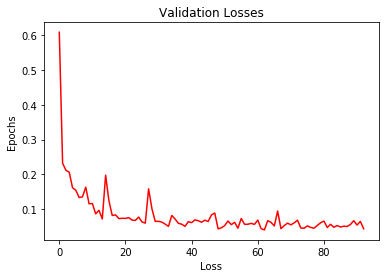

In [29]:
# Plot Validation losses

plt.plot(validation_loss, color='r')
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title('Validation Losses')

Text(0.5, 1.0, 'Validation Accuracy')

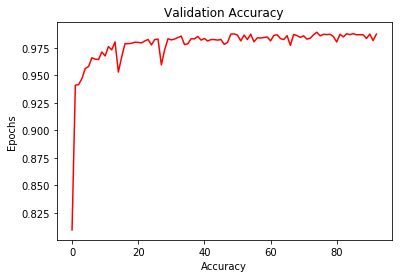

In [31]:
# Plot the validation accuracy
plt.plot(validation_acc, color='r')
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.title('Validation Accuracy')

In [33]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.listdir('gdrive/My Drive/Machine Learning Models/')
torch.save({'epochs': 10,
            'model_state_dict': model.state_dict(),
           'optimizer_state_dict': optimizer.state_dict()},'gdrive/My Drive/Machine Learning Models/resnet_50_mnist_10_epochs.pth')

In [47]:
os.listdir('gdrive/My Drive/Machine Learning Models/')

['toxic-comment-gen.h5',
 'toxic-comment-gen-compact.h5',
 'resnet_50_mnist_10_epochs.pth']